# Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, fbeta_score

from skopt.space import Integer, Categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
import shap

from skopt import BayesSearchCV

from typing import Dict, List, Literal
from skopt.space import Real, Integer, Categorical

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")

## Read dataset

In [3]:
data = pd.read_csv("../data/processed/20. FINAL_mean_delta_multi_output.csv")
print(data.shape)
data.head()

(6091, 210)


,Hba1c,Hba1c Time,Hba1c FM,Hba1c FM Time,BMI,BMI Time,Cancer,Cancer Time,Carotid Disease,Carotid Disease Time,...,y_stk_or_aemb_3_months,y_stk_or_aemb_6_months,y_stk_or_aemb_12_months,y_stk_or_aemb_24_months,y_stk_or_aemb,History of Vascular Disease,Antihypertensive Medication,Diabetes Mellitus,Diabetes Medication,Abnormal Kidney Function
0,6.26,-501,6.26,-501,20.7,-19,0,10000,0,10000,...,0,0,0,0,0,0,1,0,0,0
1,6.26,-501,6.26,-501,26.7,-780,1,-4846,0,10000,...,0,0,0,0,0,0,1,0,0,0
2,5.80,-287,6.30,-2701,31.1,-35,0,10000,0,10000,...,0,0,0,0,0,0,1,1,1,1
3,6.26,-501,6.26,-501,21.3,-207,0,10000,0,10000,...,0,0,0,0,0,1,1,0,0,1
4,5.90,-162,5.40,-5209,37.8,-554,1,-86,0,10000,...,0,0,0,0,0,1,1,1,1,0


## Drop columns

In [4]:
targets = [
    "y_stk_or_aemb_1_month", "y_stk_or_aemb_3_months", "y_stk_or_aemb_6_months", 
    "y_stk_or_aemb_12_months", "y_stk_or_aemb_24_months", "y_stk_or_aemb",

    "y_death_1_month", "y_death_3_months", "y_death_6_months", 
    "y_death_12_months", "y_death_24_months", "y_death",

    "y_cvdeath_1_month", "y_cvdeath_3_months", "y_cvdeath_6_months", 
    "y_cvdeath_12_months", "y_cvdeath_24_months", "y_cvdeath",

    "y_hf_1_month", "y_hf_3_months", "y_hf_6_months", 
    "y_hf_12_months", "y_hf_24_months", "y_hf",

    "y_inp_1_month", "y_inp_3_months", "y_inp_6_months", 
    "y_inp_12_months", "y_inp_24_months", "y_inp",

    "y_acs_1_month", "y_acs_3_months", "y_acs_6_months", 
    "y_acs_12_months", "y_acs_24_months", "y_acs"
]
# keep only target Ys, drop any other y_* cols first
cols_to_drop = [col for col in data.columns if col.startswith('y_') and col not in targets]
data_all_features = data.drop(columns=cols_to_drop)

# start longitudinal from this cleaned version
data_slope = data_all_features.copy()

# drop *_t
cols_to_drop = [col for col in data_slope.columns if col.endswith('Time')]
data_slope = data_slope.drop(columns=cols_to_drop)

# drop FM
cols_to_drop = [col for col in data_slope.columns if "FM" in col]
data_slope = data_slope.drop(columns=cols_to_drop)

# static = longitudinal without delta
data_static = data_slope.copy()

cols_to_drop = [col for col in data_slope.columns if col.startswith('Δ')]
data_static = data_static.drop(columns=cols_to_drop)


In [21]:
data_static.head()

,Hba1c,BMI,Cancer,Carotid Disease,Coronary Disease,COPD,Creatinine,DBP,Dyslipidemia,eGFR,...,y_stk_or_aemb_3_months,y_stk_or_aemb_6_months,y_stk_or_aemb_12_months,y_stk_or_aemb_24_months,y_stk_or_aemb,History of Vascular Disease,Antihypertensive Medication,Diabetes Mellitus,Diabetes Medication,Abnormal Kidney Function
0,6.26,20.7,0,0,0,0,0.99,87.0,1,64.15,...,0,0,0,0,0,0,1,0,0,0
1,6.26,26.7,1,0,0,0,0.53,81.0,0,88.50,...,0,0,0,0,0,0,1,0,0,0
2,5.80,31.1,0,0,0,0,0.88,109.0,1,46.80,...,0,0,0,0,0,0,1,1,1,1
3,6.26,21.3,0,0,0,0,1.56,63.0,1,9.00,...,0,0,0,0,0,1,1,0,0,1
4,5.90,37.8,1,0,1,0,0.64,98.0,1,76.60,...,0,0,0,0,0,1,1,1,1,0


## Models settings

In [5]:
# Define 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

# ===================== Naive Bayes =====================
search_space_nb = {
    "var_smoothing": (1e-12, 1e-1, "log-uniform")
}

nb_opt = BayesSearchCV(
    estimator=GaussianNB(),
    search_spaces=search_space_nb,
    scoring=f2_scorer,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42
)

# ===================== Logistic Regression =====================
search_space_lr = {
    'C': (1e-4, 1e+3, 'log-uniform'),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_opt = BayesSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    search_spaces=search_space_lr,
    scoring=f2_scorer,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42
)

# ===================== Decision Tree =====================
search_space_dt = {
    "max_depth": Integer(3, 20),
    "min_samples_split": Integer(2, 20),
    "min_samples_leaf": Integer(1, 10),
    "criterion": Categorical(["gini", "entropy"])
}

dt_opt = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    search_spaces=search_space_dt,
    n_iter=30,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# ===================== Random Forest =====================
search_space_rf = {
    'n_estimators': (50, 300),
    'max_depth': (1, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_opt = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces=search_space_rf,
    scoring=f2_scorer,
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=42
)

# ===================== XGBoost =====================
search_space_xgb = {
    'n_estimators': (10, 500),
    'max_depth': (1, 50),
    'learning_rate': (0.001, 0.1, 'uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 5),
    'min_child_weight': (1, 20)
}

xgb_opt = BayesSearchCV(
    XGBClassifier(random_state=42),
    search_spaces=search_space_xgb,
    scoring=f2_scorer,
    n_iter=30,
    n_jobs=-1,
    random_state=42
)

# ===================== MLP ===============================

mlp_opt = MLPClassifier(max_iter=2000, solver="adam", activation="relu", hidden_layer_sizes=(200,100), random_state=42)

# ===================== Optimizer Map =====================
optimizer_map = {
    "nb": nb_opt,
    "lr": lr_opt,
    "dt": dt_opt,
    "rf": rf_opt,
    "xgb": xgb_opt,
    "mlp": mlp_opt
}


## Define function

In [6]:
SamplingName = Literal["baseline", "undersample", "oversample", "smote", "all"]
ModelName = Literal["nb", "lr", "xgb", "dt", "rf", "mlp"]
ExplainerName = Literal["none", "linear", "tree", "kernel", "tree_rf"]

def _make_resampler(name: SamplingName, random_state: int, y_train: pd.Series = None):
    if name == "baseline":
        return None
    if name == "undersample":
        if y_train is None:
            raise ValueError("y_train must be provided for undersampling strategy")
        n_minority = y_train.sum()
        n_required = max(int(0.1 * len(y_train)), n_minority * 2)
        n_majority = n_required - n_minority
        n_majority = min(n_majority, (y_train == 0).sum())
        sampling_strategy = {0: n_majority, 1: n_minority}
        return RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    if name == "oversample":
        return RandomOverSampler(random_state=random_state)
    if name == "smote":
        return SMOTE(random_state=random_state)
    raise ValueError(f"Unknown sampling technique: {name}")

def run_cv_with_sampling(
    X_full: pd.DataFrame,
    target_cols: List[str],
    target_name: str,
    optimizer_map: Dict[ModelName, object],
    model_name: ModelName = "nb",
    sampling: SamplingName = "all",
    n_splits: int = 5,
    random_state: int = 42,
    xgb_04: bool = False,
    explainer: ExplainerName = "none",
    max_disp = 20,
) -> Dict[str, dict]:
    if target_name not in target_cols:
        raise ValueError("target_name must be inside target_cols")
    missing_targets = [c for c in target_cols if c not in X_full.columns]
    if missing_targets:
        raise ValueError(f"Target columns not in X_full: {missing_targets}")

    y = X_full[target_name].copy()
    X = X_full.drop(columns=target_cols).copy()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    if sampling == "all":
        techniques = ["baseline", "undersample", "oversample", "smote"]
    else:
        techniques = [sampling]

    results: Dict[str, dict] = {}
    fold_results: List[dict] = []   # collect across folds

    for tech in techniques:
        print(f"\n=== Technique: {tech.upper()} ===")

        fold_results = []
        best_params_per_fold: List[dict] = []

        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), start=1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            if model_name in ["nb", "lr", "mlp"]:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)

            resampler = _make_resampler(tech, random_state, y_train)
            if resampler is not None:
                X_train_rs, y_train_rs = resampler.fit_resample(X_train, y_train)
            else:
                X_train_rs, y_train_rs = X_train, y_train

            opt = optimizer_map[model_name]
            opt.fit(X_train_rs, y_train_rs)

            if model_name == "mlp":
                best_model = opt
                best_params_per_fold = {}
            else:
                best_model = opt.best_estimator_
                best_params_per_fold.append(getattr(opt, "best_params_", {}))

            y_pred = best_model.predict(X_val)

            if hasattr(best_model, "predict_proba"):
                y_pred_proba = best_model.predict_proba(X_val)[:, 1]
            else:
                scores = best_model.decision_function(X_val)
                smin, smax = scores.min(), scores.max()
                y_pred_proba = (scores - smin) / (smax - smin + 1e-9)

            if model_name == "xgb" and xgb_04:
                y_pred = (y_pred_proba >= 0.4).astype(int)

            prec = precision_score(y_val, y_pred, zero_division=0)
            rec = recall_score(y_val, y_pred, zero_division=0)
            f1 = f1_score(y_val, y_pred, zero_division=0)
            fbeta2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
            roc = roc_auc_score(y_val, y_pred_proba)

            fold_metrics = {
                "fold": fold,
                "accuracy": accuracy_score(y_val, y_pred),
                "precision": prec,
                "sensitivity": rec,
                "f1_score": f1,
                "fbeta_2": fbeta2,
                "roc_auc": roc,
                "NNS": (1 / prec) if prec > 0 else np.inf,
                "best_params": getattr(opt, "best_params_", {}),
            }
            fold_results.append(fold_metrics)

            print({k: (round(v, 3) if isinstance(v, float) else v) for k, v in fold_metrics.items()})

        metrics = [
            "accuracy",
            "precision",
            "sensitivity",
            "f1_score",
            "fbeta_2",
            "roc_auc",
            "NNS",
        ]
        mean_std = {
            m: (np.mean([fr[m] for fr in fold_results]), np.std([fr[m] for fr in fold_results]))
            for m in metrics
        }

        print("\nMean scores across folds (", tech, "):")
        for m in metrics:
            mu, sd = mean_std[m]
            print(f"{m}: {mu:.3f} \u00B1 {sd:.3f}")

        summary_df = pd.DataFrame(fold_results)
        results[tech] = {
            "fold_results": fold_results,
            "summary_metrics": summary_df,
            "best_params_per_fold": best_params_per_fold,
        }

    # ---- FINAL MODEL FIT AND SHAP ----
    best_params_overall = max(fold_results, key=lambda x: x["f1_score"])["best_params"]

    # rebuild the chosen model with best params
    if model_name == "rf":
        final_model = RandomForestClassifier(**best_params_overall)
    elif model_name == "xgb":
        final_model = XGBClassifier(**best_params_overall, use_label_encoder=False, eval_metric="logloss")
    elif model_name == "dt":
        final_model = DecisionTreeClassifier(**best_params_overall)
    elif model_name == "lr":
        final_model = LogisticRegression(**best_params_overall, max_iter=1000)
    elif model_name == "nb":
        final_model = GaussianNB(**best_params_overall)
    elif model_name == "mlp":
        final_model = MLPClassifier(**best_params_overall, max_iter=2000)
    else:
        raise ValueError(f"Unknown model_name: {model_name}")

    final_model.fit(X, y)

    if explainer != "none":
        X_background_final = X.sample(min(100, len(X)), random_state=random_state)
        X_sample_final = X.sample(min(200, len(X)), random_state=random_state)

        if explainer == "kernel":
            predict_fn_final = lambda x: final_model.predict_proba(x)[:, 1]
            shap_explainer = shap.KernelExplainer(predict_fn_final, X_background_final)
            shap_values_final = shap_explainer.shap_values(X_sample_final)
        elif explainer == "tree":
            shap_explainer = shap.TreeExplainer(final_model)
            shap_values_final = shap_explainer.shap_values(X_sample_final)
        elif explainer == "linear":
            shap_explainer = shap.LinearExplainer(final_model, X_background_final)
            shap_values_final = shap_explainer.shap_values(X_sample_final)
        elif explainer == "tree_rf":
            shap_explainer = shap.TreeExplainer(final_model)
            shap_values_final = shap_explainer.shap_values(X_sample_final)
            
            shap.summary_plot(
                shap_values_final[:, :, 1],
                X_sample_final,
                feature_names=X.columns,
                max_display=max_disp
            )
        
        if explainer != "tree_rf":
            shap.summary_plot(
                shap_values_final,
                X_sample_final,
                feature_names=X.columns,
                max_display=max_disp
            )

    return results

## Stroke slope based LR


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.544, 'precision': 0.03, 'sensitivity': 0.607, 'f1_score': 0.058, 'fbeta_2': 0.126, 'roc_auc': np.float64(0.619), 'NNS': 33.059, 'best_params': OrderedDict([('C', 0.0001988381180672849), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.49, 'precision': 0.029, 'sensitivity': 0.667, 'f1_score': 0.055, 'fbeta_2': 0.122, 'roc_auc': np.float64(0.607), 'NNS': 35.0, 'best_params': OrderedDict([('C', 0.00010602594470834996), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.53, 'precision': 0.033, 'sensitivity': 0.704, 'f1_score': 0.062, 'fbeta_2': 0.137, 'roc_auc': np.float64(0.637), 'NNS': 30.737, 'best_params': OrderedDict([('C', 0.00010602594470834996), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.518, 'precision': 0.027, 'sensitivity': 0.593, 'f1_score': 0.052, 'fbeta_2': 0.114, 'roc_auc': np.float64(0.588), 'NNS': 37.0, 'best_params': OrderedDict([('C', 0.00010602594

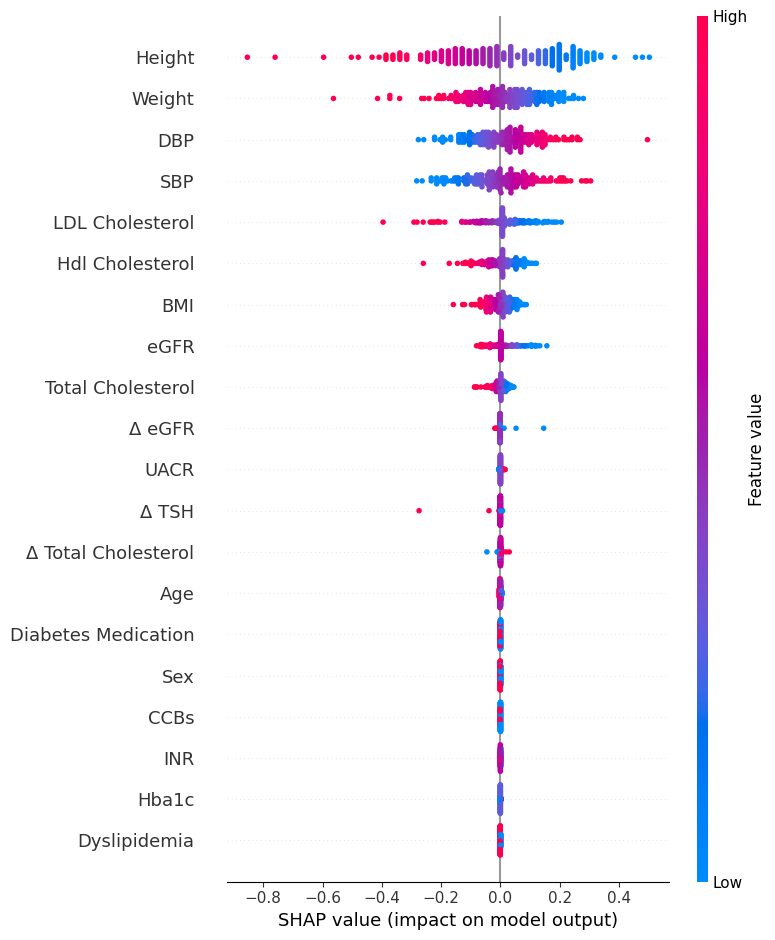

In [24]:
results = run_cv_with_sampling(
    X_full=data_slope,
    target_cols=targets,
    target_name="y_stk_or_aemb",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear"
)


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.544, 'precision': 0.03, 'sensitivity': 0.607, 'f1_score': 0.058, 'fbeta_2': 0.126, 'roc_auc': np.float64(0.619), 'NNS': 33.059, 'best_params': OrderedDict([('C', 0.0001988381180672849), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.49, 'precision': 0.029, 'sensitivity': 0.667, 'f1_score': 0.055, 'fbeta_2': 0.122, 'roc_auc': np.float64(0.607), 'NNS': 35.0, 'best_params': OrderedDict([('C', 0.00010602594470834996), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.53, 'precision': 0.033, 'sensitivity': 0.704, 'f1_score': 0.062, 'fbeta_2': 0.137, 'roc_auc': np.float64(0.637), 'NNS': 30.737, 'best_params': OrderedDict([('C', 0.00010602594470834996), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.518, 'precision': 0.027, 'sensitivity': 0.593, 'f1_score': 0.052, 'fbeta_2': 0.114, 'roc_auc': np.float64(0.588), 'NNS': 37.0, 'best_params': OrderedDict([('C', 0.00010602594

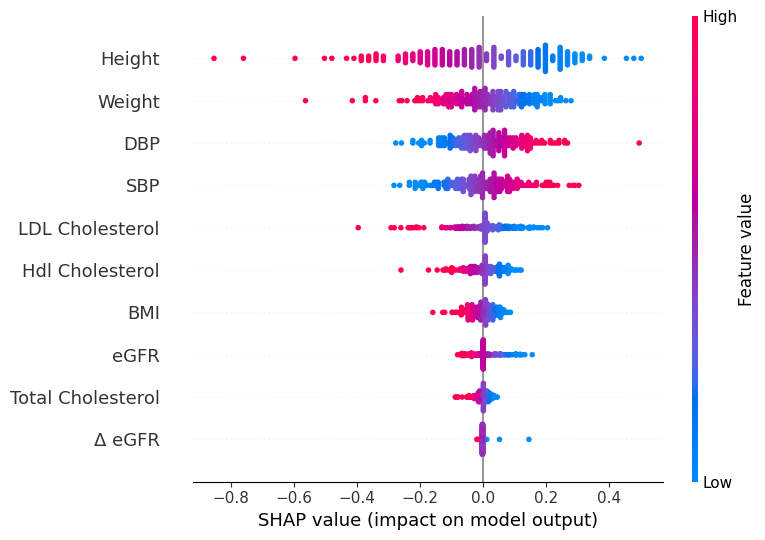

In [26]:
results = run_cv_with_sampling(
    X_full=data_slope,
    target_cols=targets,
    target_name="y_stk_or_aemb",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear",
    max_disp=10
)

## all-cause death 
- longitudinal xgb
- static lr


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.674, 'precision': 0.096, 'sensitivity': 0.667, 'f1_score': 0.168, 'fbeta_2': 0.304, 'roc_auc': np.float64(0.745), 'NNS': 10.425, 'best_params': OrderedDict([('colsample_bytree', 0.8309322448615906), ('gamma', 5), ('learning_rate', 0.06842439703369384), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 80), ('subsample', 0.7501929799439746)])}
{'fold': 2, 'accuracy': 0.7, 'precision': 0.113, 'sensitivity': 0.763, 'f1_score': 0.197, 'fbeta_2': 0.355, 'roc_auc': np.float64(0.764), 'NNS': 8.822, 'best_params': OrderedDict([('colsample_bytree', 0.5072918751629665), ('gamma', 5), ('learning_rate', 0.06206823564283474), ('max_depth', 34), ('min_child_weight', 1), ('n_estimators', 242), ('subsample', 0.8783455991824893)])}
{'fold': 3, 'accuracy': 0.731, 'precision': 0.127, 'sensitivity': 0.78, 'f1_score': 0.219, 'fbeta_2': 0.385, 'roc_auc': np.float64(0.825), 'NNS': 7.848, 'best_params': OrderedDict([('colsample_bytree', 0.808

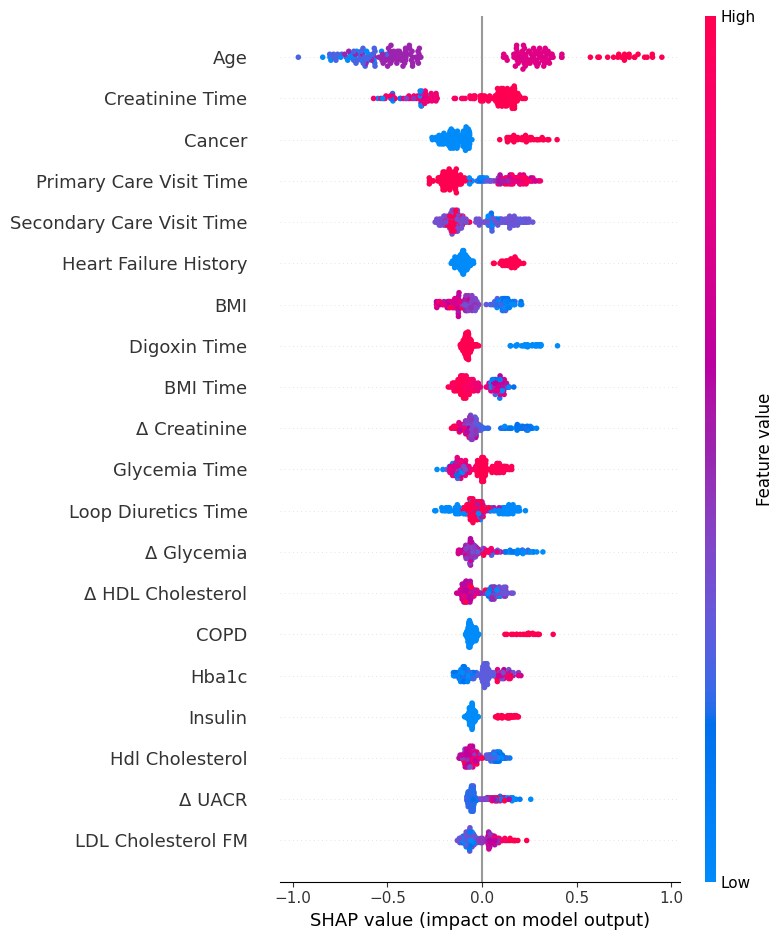

In [15]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_death_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.674, 'precision': 0.096, 'sensitivity': 0.667, 'f1_score': 0.168, 'fbeta_2': 0.304, 'roc_auc': np.float64(0.745), 'NNS': 10.425, 'best_params': OrderedDict([('colsample_bytree', 0.8309322448615906), ('gamma', 5), ('learning_rate', 0.06842439703369384), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 80), ('subsample', 0.7501929799439746)])}
{'fold': 2, 'accuracy': 0.7, 'precision': 0.113, 'sensitivity': 0.763, 'f1_score': 0.197, 'fbeta_2': 0.355, 'roc_auc': np.float64(0.764), 'NNS': 8.822, 'best_params': OrderedDict([('colsample_bytree', 0.5072918751629665), ('gamma', 5), ('learning_rate', 0.06206823564283474), ('max_depth', 34), ('min_child_weight', 1), ('n_estimators', 242), ('subsample', 0.8783455991824893)])}
{'fold': 3, 'accuracy': 0.731, 'precision': 0.127, 'sensitivity': 0.78, 'f1_score': 0.219, 'fbeta_2': 0.385, 'roc_auc': np.float64(0.825), 'NNS': 7.848, 'best_params': OrderedDict([('colsample_bytree', 0.808

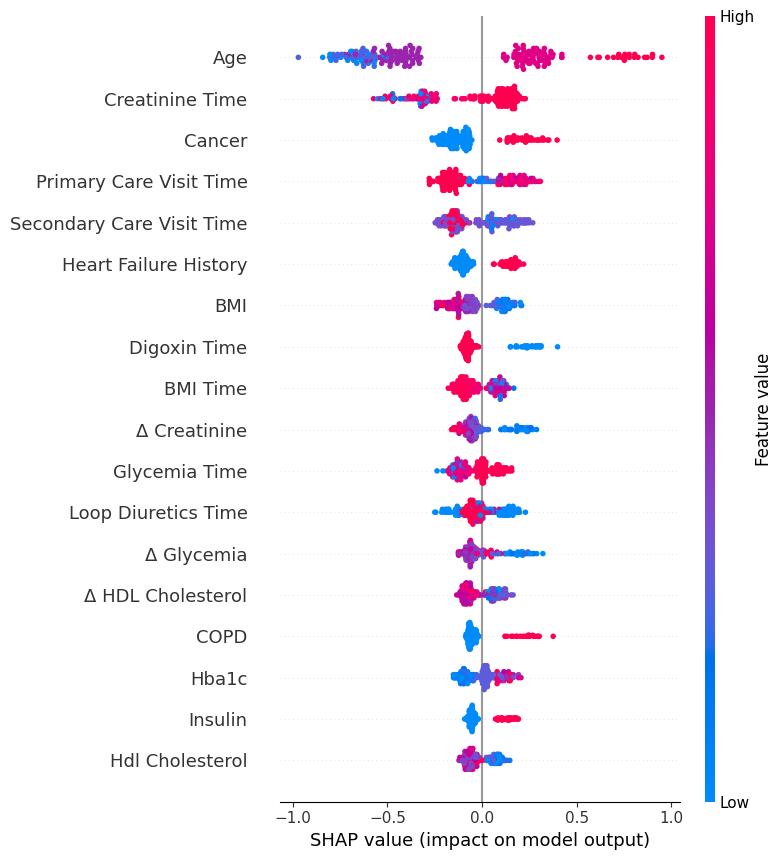

In [27]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_death_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree",
    max_disp=18
)


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.642, 'precision': 0.095, 'sensitivity': 0.733, 'f1_score': 0.168, 'fbeta_2': 0.312, 'roc_auc': np.float64(0.747), 'NNS': 10.545, 'best_params': OrderedDict([('C', 0.0005879792726575813), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.571, 'precision': 0.09, 'sensitivity': 0.864, 'f1_score': 0.163, 'fbeta_2': 0.318, 'roc_auc': np.float64(0.797), 'NNS': 11.098, 'best_params': OrderedDict([('C', 0.00018023154050241845), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.598, 'precision': 0.094, 'sensitivity': 0.847, 'f1_score': 0.169, 'fbeta_2': 0.326, 'roc_auc': np.float64(0.778), 'NNS': 10.62, 'best_params': OrderedDict([('C', 0.0001929442173127865), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.66, 'precision': 0.099, 'sensitivity': 0.746, 'f1_score': 0.175, 'fbeta_2': 0.324, 'roc_auc': np.float64(0.756), 'NNS': 10.068, 'best_params': OrderedDict([('C', 0.00055613

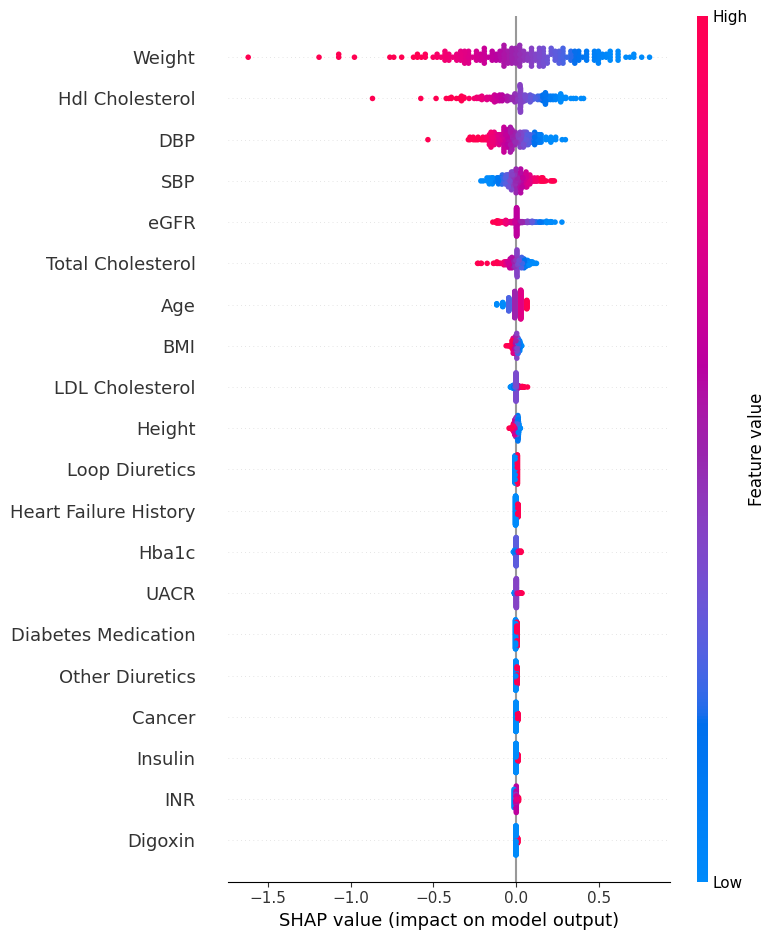

In [16]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_death_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear"
)


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.642, 'precision': 0.095, 'sensitivity': 0.733, 'f1_score': 0.168, 'fbeta_2': 0.312, 'roc_auc': np.float64(0.747), 'NNS': 10.545, 'best_params': OrderedDict([('C', 0.0005879792726575813), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.571, 'precision': 0.09, 'sensitivity': 0.864, 'f1_score': 0.163, 'fbeta_2': 0.318, 'roc_auc': np.float64(0.797), 'NNS': 11.098, 'best_params': OrderedDict([('C', 0.00018023154050241845), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.598, 'precision': 0.094, 'sensitivity': 0.847, 'f1_score': 0.169, 'fbeta_2': 0.326, 'roc_auc': np.float64(0.778), 'NNS': 10.62, 'best_params': OrderedDict([('C', 0.0001929442173127865), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.66, 'precision': 0.099, 'sensitivity': 0.746, 'f1_score': 0.175, 'fbeta_2': 0.324, 'roc_auc': np.float64(0.756), 'NNS': 10.068, 'best_params': OrderedDict([('C', 0.00055613

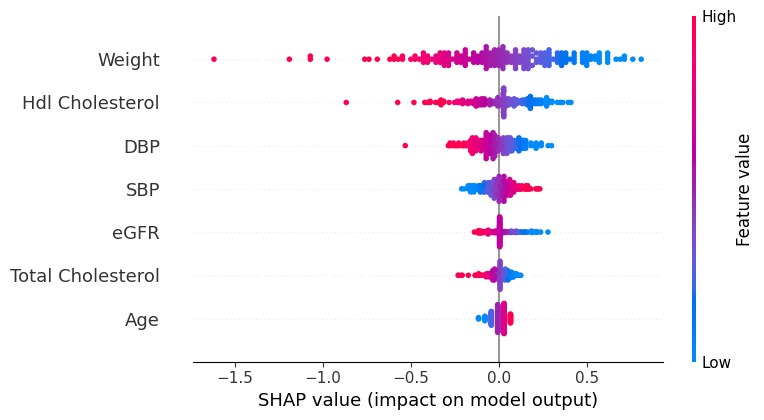

In [28]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_death_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear",
    max_disp = 7
)

## cv death


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.824, 'precision': 0.099, 'sensitivity': 0.467, 'f1_score': 0.163, 'fbeta_2': 0.268, 'roc_auc': np.float64(0.75), 'NNS': 10.095, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 41), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 12), ('n_estimators', 119)])}
{'fold': 2, 'accuracy': 0.844, 'precision': 0.099, 'sensitivity': 0.409, 'f1_score': 0.159, 'fbeta_2': 0.251, 'roc_auc': np.float64(0.739), 'NNS': 10.111, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 27), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 20), ('n_estimators', 50)])}
{'fold': 3, 'accuracy': 0.819, 'precision': 0.107, 'sensitivity': 0.545, 'f1_score': 0.178, 'fbeta_2': 0.299, 'roc_auc': np.float64(0.765), 'NNS': 9.375, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 26), ('max_features', None), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 300)])}


  0%|          | 0/200 [00:00<?, ?it/s]

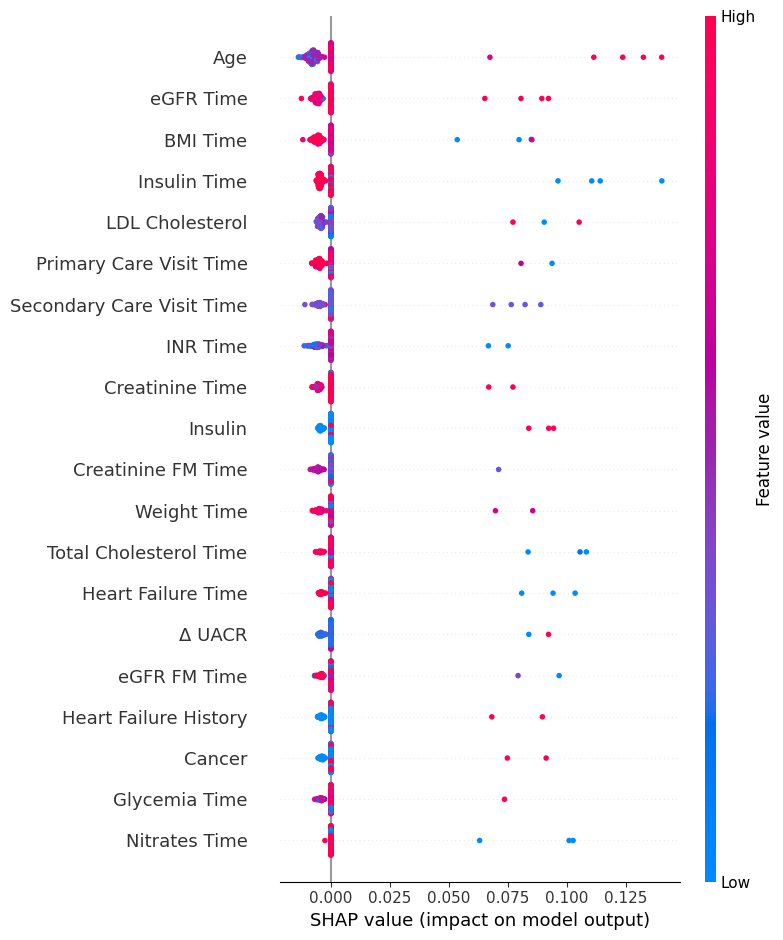

In [ ]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_cvdeath_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="kernel"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.824, 'precision': 0.099, 'sensitivity': 0.467, 'f1_score': 0.163, 'fbeta_2': 0.268, 'roc_auc': np.float64(0.75), 'NNS': 10.095, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 41), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 12), ('n_estimators', 119)])}
{'fold': 2, 'accuracy': 0.844, 'precision': 0.099, 'sensitivity': 0.409, 'f1_score': 0.159, 'fbeta_2': 0.251, 'roc_auc': np.float64(0.739), 'NNS': 10.111, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 27), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 20), ('n_estimators', 50)])}
{'fold': 3, 'accuracy': 0.819, 'precision': 0.107, 'sensitivity': 0.545, 'f1_score': 0.178, 'fbeta_2': 0.299, 'roc_auc': np.float64(0.765), 'NNS': 9.375, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 26), ('max_features', None), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 300)])}


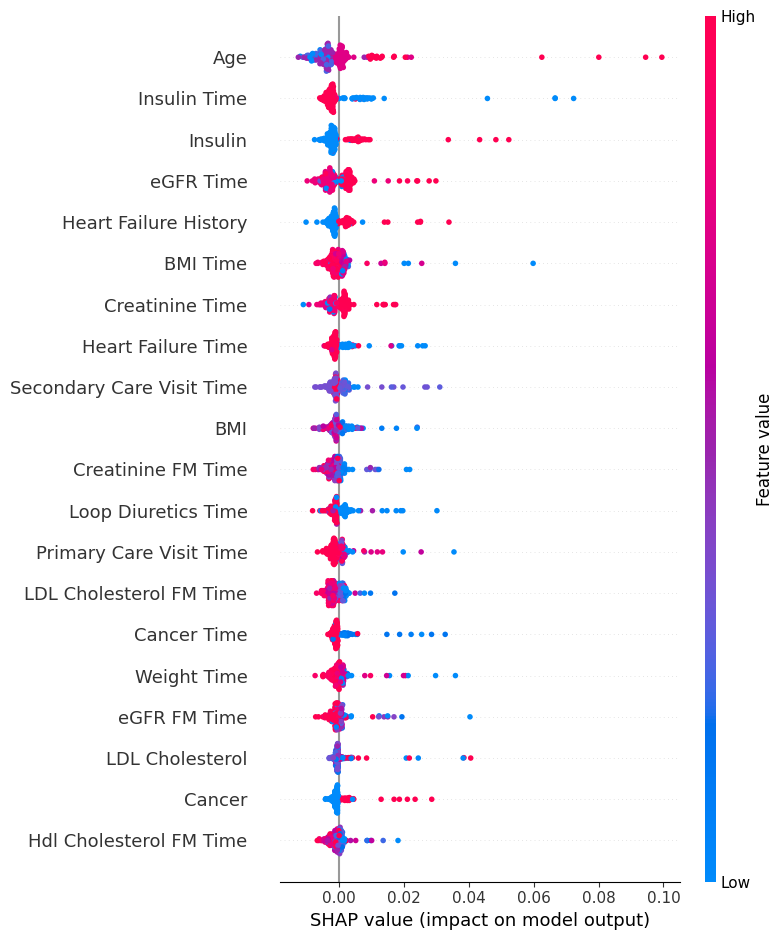

In [32]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_cvdeath_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree_rf"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.824, 'precision': 0.099, 'sensitivity': 0.467, 'f1_score': 0.163, 'fbeta_2': 0.268, 'roc_auc': np.float64(0.75), 'NNS': 10.095, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 41), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 12), ('n_estimators', 119)])}
{'fold': 2, 'accuracy': 0.844, 'precision': 0.099, 'sensitivity': 0.409, 'f1_score': 0.159, 'fbeta_2': 0.251, 'roc_auc': np.float64(0.739), 'NNS': 10.111, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 27), ('max_features', None), ('min_samples_leaf', 6), ('min_samples_split', 20), ('n_estimators', 50)])}
{'fold': 3, 'accuracy': 0.819, 'precision': 0.107, 'sensitivity': 0.545, 'f1_score': 0.178, 'fbeta_2': 0.299, 'roc_auc': np.float64(0.765), 'NNS': 9.375, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 26), ('max_features', None), ('min_samples_leaf', 2), ('min_samples_split', 5), ('n_estimators', 300)])}


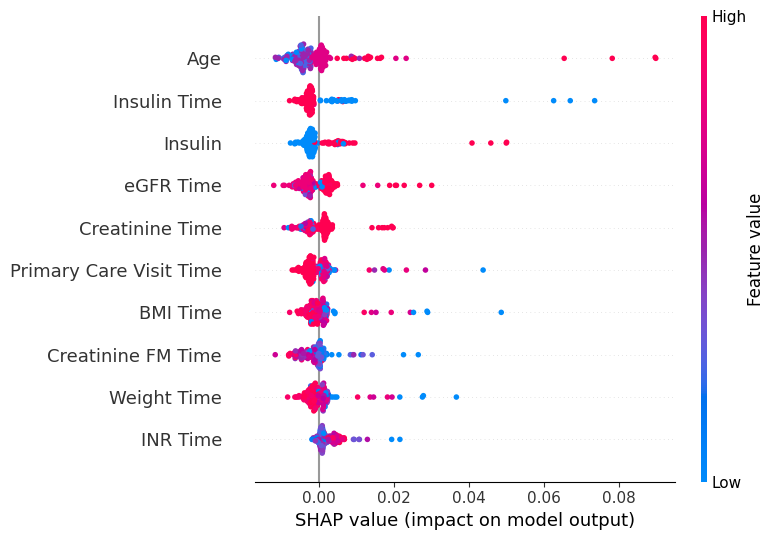

In [33]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_cvdeath_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree_rf",
    max_disp=10
)


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.652, 'precision': 0.08, 'sensitivity': 0.8, 'f1_score': 0.145, 'fbeta_2': 0.285, 'roc_auc': np.float64(0.768), 'NNS': 12.528, 'best_params': OrderedDict([('C', 0.0005491559094000247), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.684, 'precision': 0.079, 'sensitivity': 0.727, 'f1_score': 0.143, 'fbeta_2': 0.275, 'roc_auc': np.float64(0.768), 'NNS': 12.656, 'best_params': OrderedDict([('C', 0.0009769708347079002), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.613, 'precision': 0.077, 'sensitivity': 0.886, 'f1_score': 0.142, 'fbeta_2': 0.286, 'roc_auc': np.float64(0.783), 'NNS': 12.949, 'best_params': OrderedDict([('C', 0.0003265810249839299), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.673, 'precision': 0.077, 'sensitivity': 0.711, 'f1_score': 0.139, 'fbeta_2': 0.268, 'roc_auc': np.float64(0.748), 'NNS': 13.031, 'best_params': OrderedDict([('C', 0.000777195

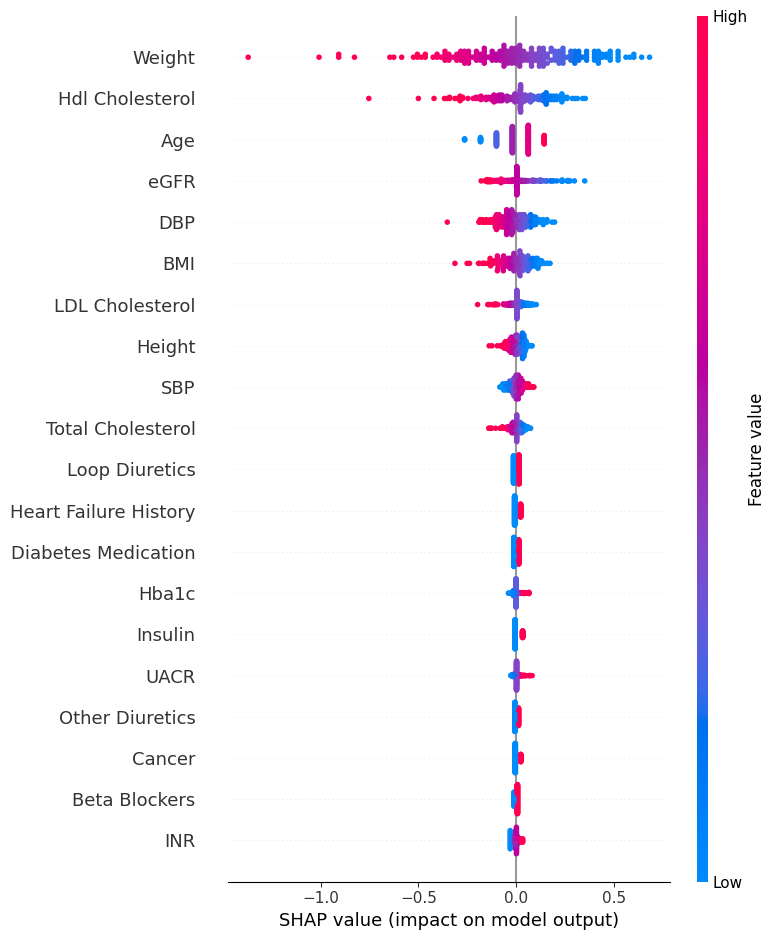

In [ ]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_cvdeath_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear"
)


=== Technique: SMOTE ===
{'fold': 1, 'accuracy': 0.652, 'precision': 0.08, 'sensitivity': 0.8, 'f1_score': 0.145, 'fbeta_2': 0.285, 'roc_auc': np.float64(0.768), 'NNS': 12.528, 'best_params': OrderedDict([('C', 0.0005491559094000247), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.684, 'precision': 0.079, 'sensitivity': 0.727, 'f1_score': 0.143, 'fbeta_2': 0.275, 'roc_auc': np.float64(0.768), 'NNS': 12.656, 'best_params': OrderedDict([('C', 0.0009769708347079002), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.613, 'precision': 0.077, 'sensitivity': 0.886, 'f1_score': 0.142, 'fbeta_2': 0.286, 'roc_auc': np.float64(0.783), 'NNS': 12.949, 'best_params': OrderedDict([('C', 0.0003265810249839299), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.673, 'precision': 0.077, 'sensitivity': 0.711, 'f1_score': 0.139, 'fbeta_2': 0.268, 'roc_auc': np.float64(0.748), 'NNS': 13.031, 'best_params': OrderedDict([('C', 0.000777195

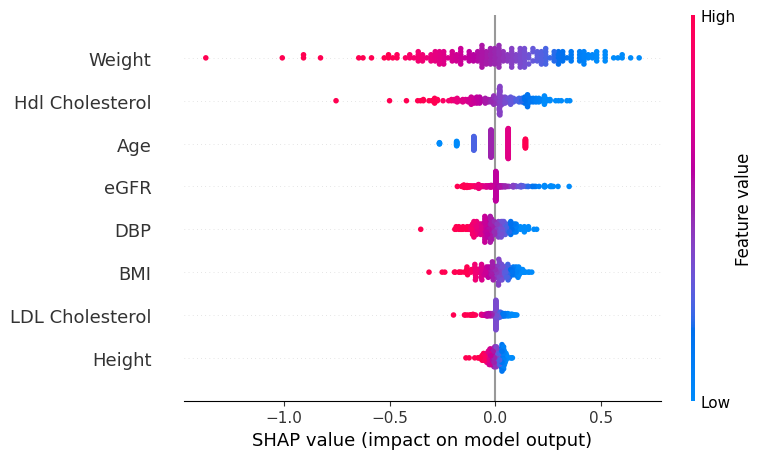

In [34]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_cvdeath_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="smote",
    n_splits=5,
    random_state=42,
    explainer="linear",
    max_disp=8
)

## HF hosp


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.633, 'precision': 0.226, 'sensitivity': 0.808, 'f1_score': 0.353, 'fbeta_2': 0.533, 'roc_auc': np.float64(0.768), 'NNS': 4.426, 'best_params': OrderedDict([('colsample_bytree', 1.0), ('gamma', 3), ('learning_rate', 0.001), ('max_depth', 1), ('min_child_weight', 20), ('n_estimators', 203), ('subsample', 0.5)])}
{'fold': 2, 'accuracy': 0.72, 'precision': 0.273, 'sensitivity': 0.767, 'f1_score': 0.403, 'fbeta_2': 0.563, 'roc_auc': np.float64(0.79), 'NNS': 3.661, 'best_params': OrderedDict([('colsample_bytree', 0.8085396792511581), ('gamma', 4), ('learning_rate', 0.036543270260218995), ('max_depth', 44), ('min_child_weight', 12), ('n_estimators', 301), ('subsample', 0.8243887548518629)])}
{'fold': 3, 'accuracy': 0.743, 'precision': 0.294, 'sensitivity': 0.768, 'f1_score': 0.426, 'fbeta_2': 0.581, 'roc_auc': np.float64(0.812), 'NNS': 3.397, 'best_params': OrderedDict([('colsample_bytree', 0.9097517663877747), ('gamma', 2), ('learning

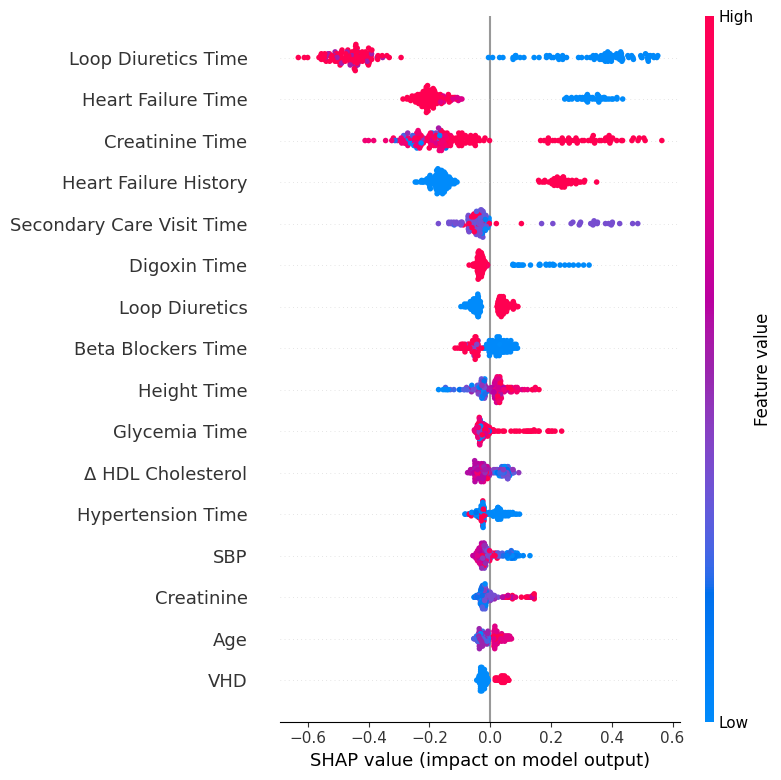

In [35]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_hf_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree",
    max_disp=16
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.673, 'precision': 0.243, 'sensitivity': 0.775, 'f1_score': 0.37, 'fbeta_2': 0.539, 'roc_auc': np.float64(0.749), 'NNS': 4.12, 'best_params': OrderedDict([('colsample_bytree', 0.5604633606673581), ('gamma', 5), ('learning_rate', 0.1), ('max_depth', 36), ('min_child_weight', 14), ('n_estimators', 10), ('subsample', 1.0)])}
{'fold': 2, 'accuracy': 0.647, 'precision': 0.224, 'sensitivity': 0.76, 'f1_score': 0.347, 'fbeta_2': 0.514, 'roc_auc': np.float64(0.751), 'NNS': 4.456, 'best_params': OrderedDict([('colsample_bytree', 0.8260367457426929), ('gamma', 5), ('learning_rate', 0.003384429637393834), ('max_depth', 33), ('min_child_weight', 1), ('n_estimators', 10), ('subsample', 0.5370531719943081)])}
{'fold': 3, 'accuracy': 0.725, 'precision': 0.278, 'sensitivity': 0.762, 'f1_score': 0.407, 'fbeta_2': 0.565, 'roc_auc': np.float64(0.795), 'NNS': 3.6, 'best_params': OrderedDict([('colsample_bytree', 0.6091886815818075), ('gamma', 0), ('

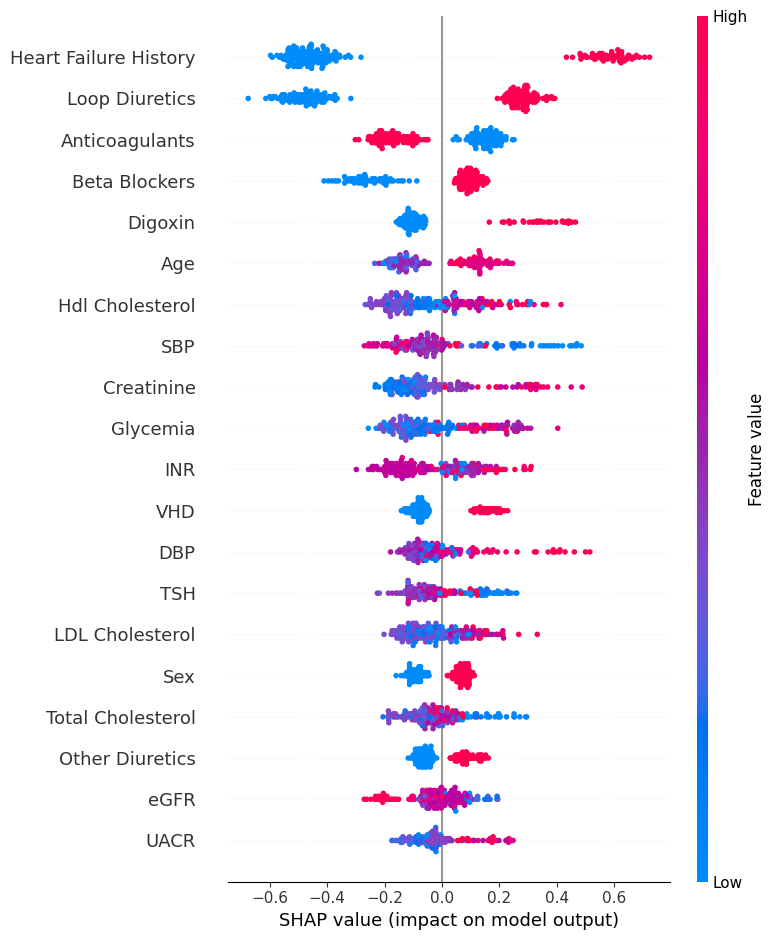

In [18]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_hf_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree"
)

## Inpatietn visit - slope based rf


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.601, 'precision': 0.306, 'sensitivity': 0.678, 'f1_score': 0.421, 'fbeta_2': 0.545, 'roc_auc': np.float64(0.673), 'NNS': 3.271, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 16), ('max_features', None), ('min_samples_leaf', 3), ('min_samples_split', 18), ('n_estimators', 147)])}
{'fold': 2, 'accuracy': 0.589, 'precision': 0.3, 'sensitivity': 0.696, 'f1_score': 0.419, 'fbeta_2': 0.551, 'roc_auc': np.float64(0.681), 'NNS': 3.331, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 48), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 200)])}
{'fold': 3, 'accuracy': 0.606, 'precision': 0.307, 'sensitivity': 0.673, 'f1_score': 0.422, 'fbeta_2': 0.543, 'roc_auc': np.float64(0.667), 'NNS': 3.257, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 32), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 223)]

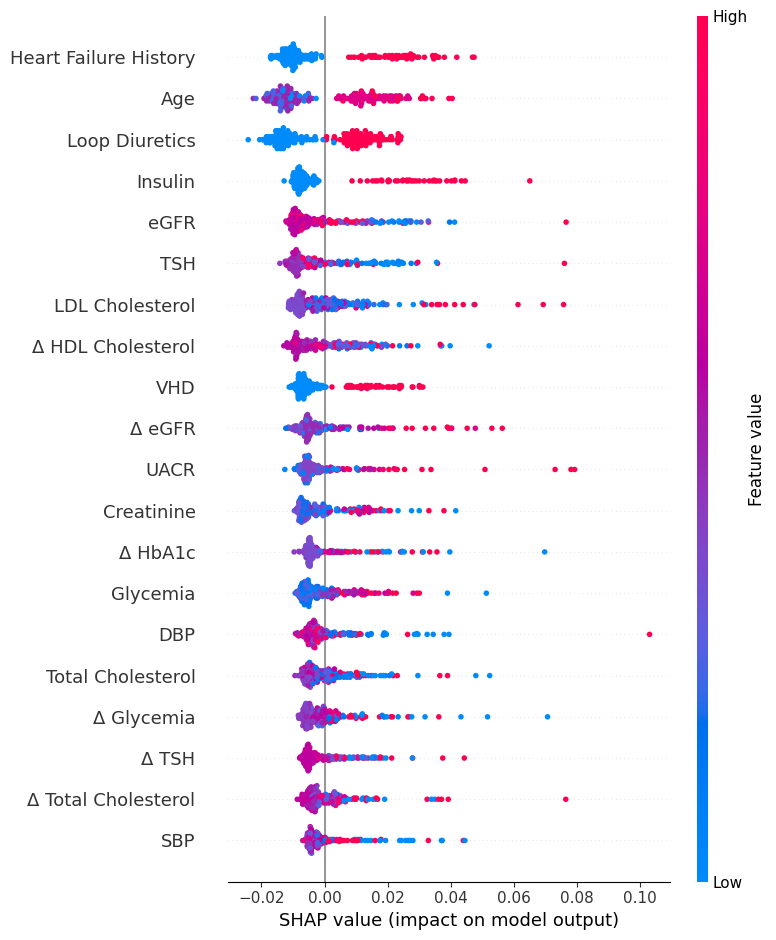

In [36]:
results = run_cv_with_sampling(
    X_full=data_slope,
    target_cols=targets,
    target_name="y_inp_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree_rf"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.601, 'precision': 0.306, 'sensitivity': 0.678, 'f1_score': 0.421, 'fbeta_2': 0.545, 'roc_auc': np.float64(0.673), 'NNS': 3.271, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 16), ('max_features', None), ('min_samples_leaf', 3), ('min_samples_split', 18), ('n_estimators', 147)])}
{'fold': 2, 'accuracy': 0.589, 'precision': 0.3, 'sensitivity': 0.696, 'f1_score': 0.419, 'fbeta_2': 0.551, 'roc_auc': np.float64(0.681), 'NNS': 3.331, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 48), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 200)])}
{'fold': 3, 'accuracy': 0.606, 'precision': 0.307, 'sensitivity': 0.673, 'f1_score': 0.422, 'fbeta_2': 0.543, 'roc_auc': np.float64(0.667), 'NNS': 3.257, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 32), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 223)]

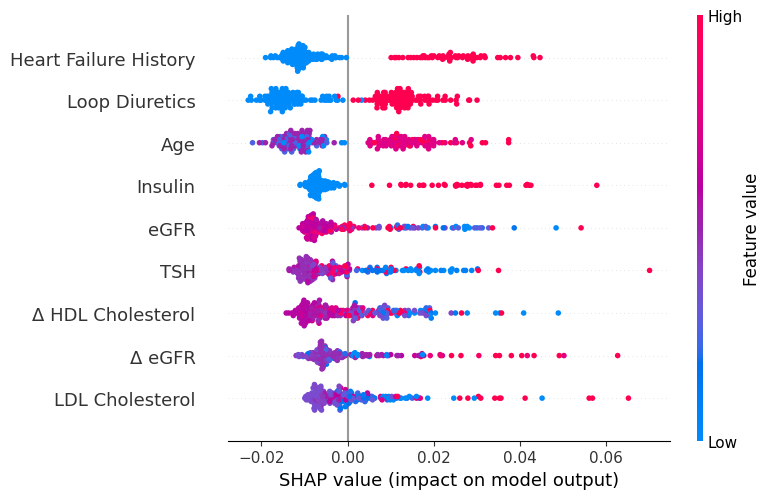

In [41]:
results = run_cv_with_sampling(
    X_full=data_slope,
    target_cols=targets,
    target_name="y_inp_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree_rf",
    max_disp=9
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.601, 'precision': 0.306, 'sensitivity': 0.678, 'f1_score': 0.421, 'fbeta_2': 0.545, 'roc_auc': np.float64(0.673), 'NNS': 3.271, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 16), ('max_features', None), ('min_samples_leaf', 3), ('min_samples_split', 18), ('n_estimators', 147)])}
{'fold': 2, 'accuracy': 0.589, 'precision': 0.3, 'sensitivity': 0.696, 'f1_score': 0.419, 'fbeta_2': 0.551, 'roc_auc': np.float64(0.681), 'NNS': 3.331, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 48), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 200)])}
{'fold': 3, 'accuracy': 0.606, 'precision': 0.307, 'sensitivity': 0.673, 'f1_score': 0.422, 'fbeta_2': 0.543, 'roc_auc': np.float64(0.667), 'NNS': 3.257, 'best_params': OrderedDict([('bootstrap', True), ('max_depth', 32), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 20), ('n_estimators', 223)]

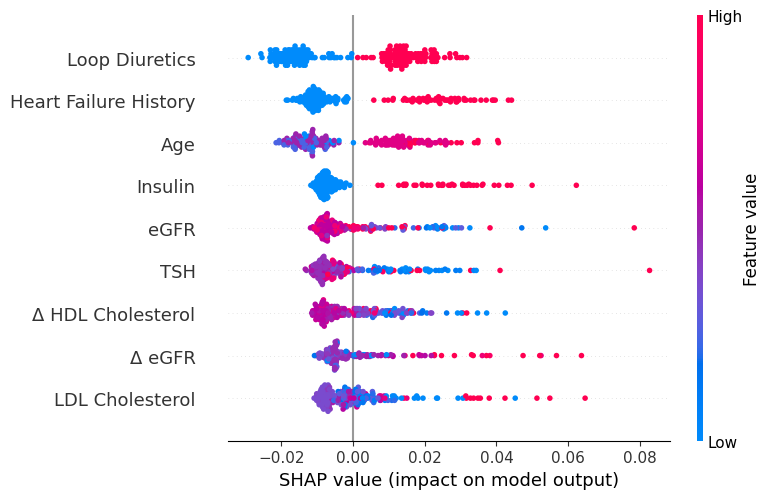

In [37]:
results = run_cv_with_sampling(
    X_full=data_slope,
    target_cols=targets,
    target_name="y_inp_6_months",
    optimizer_map=optimizer_map,
    model_name="rf",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree_rf",
    max_disp=9
)

## ACS longitudinal XGBooost, static MLP


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.957, 'precision': 0.068, 'sensitivity': 0.2, 'f1_score': 0.102, 'fbeta_2': 0.144, 'roc_auc': np.float64(0.628), 'NNS': 14.667, 'best_params': OrderedDict([('colsample_bytree', 0.5), ('gamma', 0), ('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 356), ('subsample', 0.5)])}
{'fold': 2, 'accuracy': 0.961, 'precision': 0.075, 'sensitivity': 0.214, 'f1_score': 0.111, 'fbeta_2': 0.156, 'roc_auc': np.float64(0.764), 'NNS': 13.333, 'best_params': OrderedDict([('colsample_bytree', 0.5814312884639665), ('gamma', 0), ('learning_rate', 0.1), ('max_depth', 50), ('min_child_weight', 4), ('n_estimators', 293), ('subsample', 1.0)])}
{'fold': 3, 'accuracy': 0.962, 'precision': 0.1, 'sensitivity': 0.286, 'f1_score': 0.148, 'fbeta_2': 0.208, 'roc_auc': np.float64(0.814), 'NNS': 10.0, 'best_params': OrderedDict([('colsample_bytree', 0.9591391638846221), ('gamma', 2), ('learning_rate', 0.1), ('max_depth', 11), ('mi

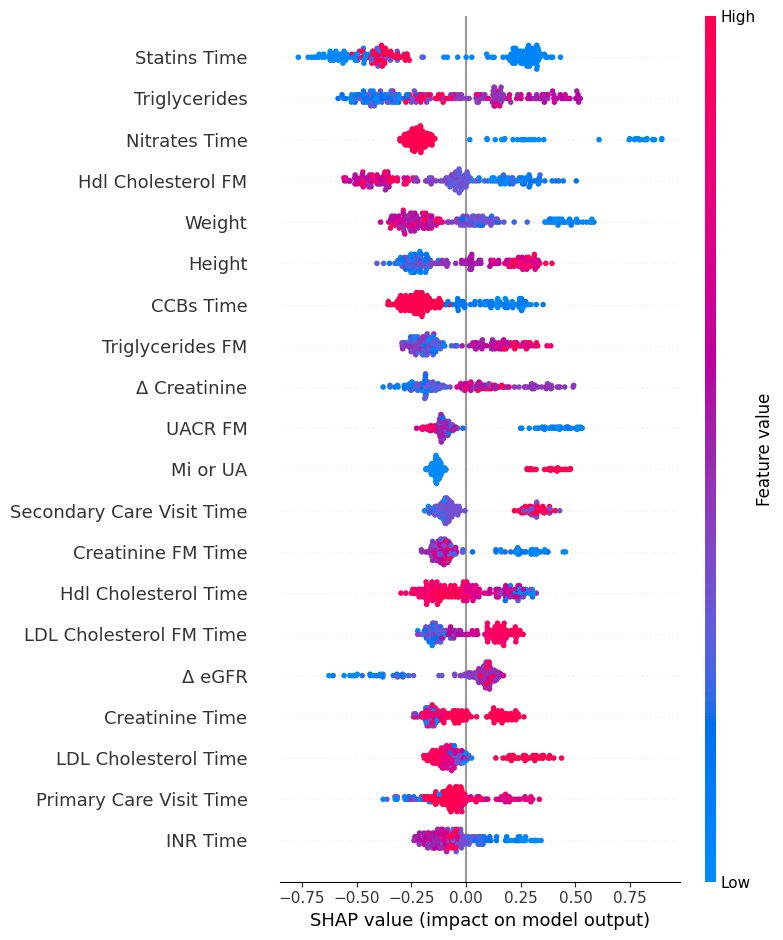

In [7]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.957, 'precision': 0.068, 'sensitivity': 0.2, 'f1_score': 0.102, 'fbeta_2': 0.144, 'roc_auc': np.float64(0.628), 'NNS': 14.667, 'best_params': OrderedDict([('colsample_bytree', 0.5), ('gamma', 0), ('learning_rate', 0.1), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 356), ('subsample', 0.5)])}
{'fold': 2, 'accuracy': 0.961, 'precision': 0.075, 'sensitivity': 0.214, 'f1_score': 0.111, 'fbeta_2': 0.156, 'roc_auc': np.float64(0.764), 'NNS': 13.333, 'best_params': OrderedDict([('colsample_bytree', 0.5814312884639665), ('gamma', 0), ('learning_rate', 0.1), ('max_depth', 50), ('min_child_weight', 4), ('n_estimators', 293), ('subsample', 1.0)])}
{'fold': 3, 'accuracy': 0.962, 'precision': 0.1, 'sensitivity': 0.286, 'f1_score': 0.148, 'fbeta_2': 0.208, 'roc_auc': np.float64(0.814), 'NNS': 10.0, 'best_params': OrderedDict([('colsample_bytree', 0.9591391638846221), ('gamma', 2), ('learning_rate', 0.1), ('max_depth', 11), ('mi

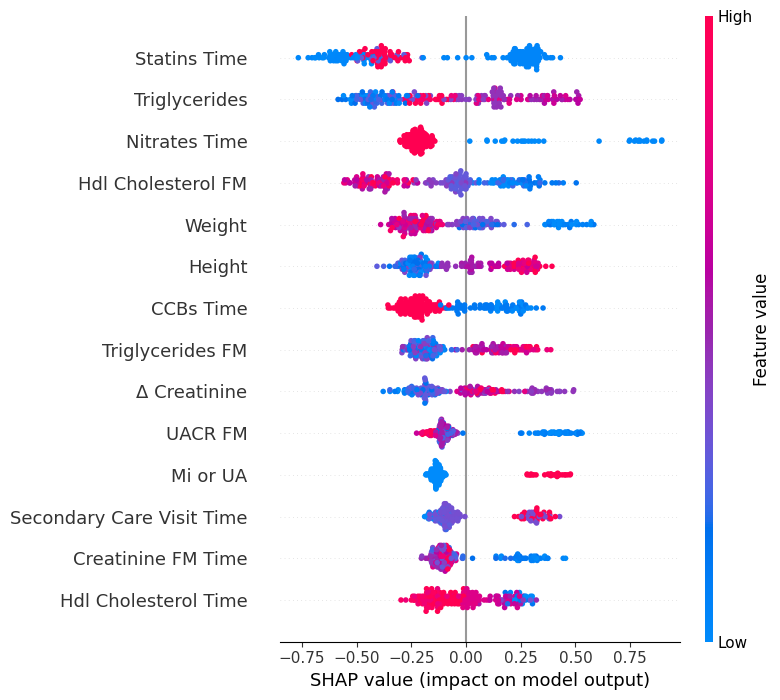

In [42]:
results = run_cv_with_sampling(
    X_full=data_all_features,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="xgb",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="tree",
    max_disp= 14
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.955, 'precision': 0.083, 'sensitivity': 0.267, 'f1_score': 0.127, 'fbeta_2': 0.185, 'roc_auc': np.float64(0.685), 'NNS': 12.0, 'best_params': {}}
{'fold': 2, 'accuracy': 0.933, 'precision': 0.076, 'sensitivity': 0.429, 'f1_score': 0.129, 'fbeta_2': 0.222, 'roc_auc': np.float64(0.715), 'NNS': 13.167, 'best_params': {}}
{'fold': 3, 'accuracy': 0.947, 'precision': 0.037, 'sensitivity': 0.143, 'f1_score': 0.059, 'fbeta_2': 0.091, 'roc_auc': np.float64(0.67), 'NNS': 27.0, 'best_params': {}}
{'fold': 4, 'accuracy': 0.94, 'precision': 0.032, 'sensitivity': 0.143, 'f1_score': 0.052, 'fbeta_2': 0.084, 'roc_auc': np.float64(0.699), 'NNS': 31.5, 'best_params': {}}
{'fold': 5, 'accuracy': 0.948, 'precision': 0.056, 'sensitivity': 0.2, 'f1_score': 0.087, 'fbeta_2': 0.132, 'roc_auc': np.float64(0.619), 'NNS': 18.0, 'best_params': {}}

Mean scores across folds ( undersample ):
accuracy: 0.945 ± 0.007
precision: 0.057 ± 0.020
sensitivity: 0.236

  0%|          | 0/200 [00:00<?, ?it/s]

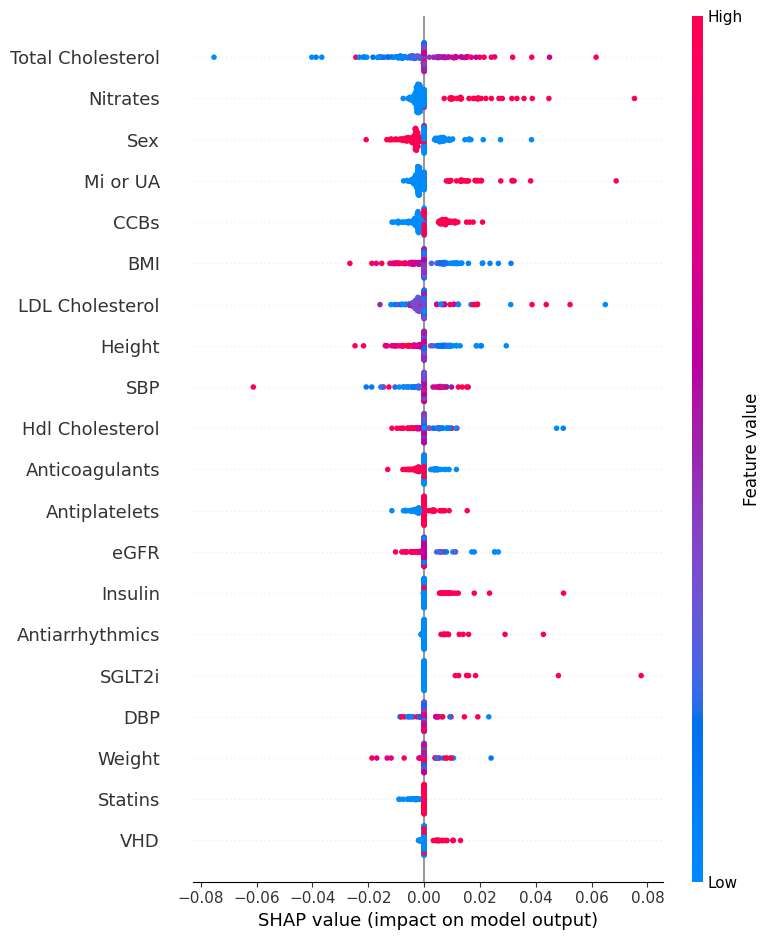

In [8]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="mlp",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="kernel"
)


=== Technique: BASELINE ===
{'fold': 1, 'accuracy': 0.823, 'precision': 0.041, 'sensitivity': 0.6, 'f1_score': 0.077, 'fbeta_2': 0.161, 'roc_auc': np.float64(0.775), 'NNS': 24.333, 'best_params': OrderedDict([('var_smoothing', 0.1)])}
{'fold': 2, 'accuracy': 0.833, 'precision': 0.043, 'sensitivity': 0.643, 'f1_score': 0.081, 'fbeta_2': 0.171, 'roc_auc': np.float64(0.756), 'NNS': 23.0, 'best_params': OrderedDict([('var_smoothing', 0.1)])}
{'fold': 3, 'accuracy': 0.859, 'precision': 0.041, 'sensitivity': 0.5, 'f1_score': 0.075, 'fbeta_2': 0.154, 'roc_auc': np.float64(0.76), 'NNS': 24.571, 'best_params': OrderedDict([('var_smoothing', 0.09912740922751373)])}
{'fold': 4, 'accuracy': 0.842, 'precision': 0.027, 'sensitivity': 0.357, 'f1_score': 0.05, 'fbeta_2': 0.102, 'roc_auc': np.float64(0.725), 'NNS': 37.6, 'best_params': OrderedDict([('var_smoothing', 0.0412947837564389)])}
{'fold': 5, 'accuracy': 0.868, 'precision': 0.026, 'sensitivity': 0.267, 'f1_score': 0.047, 'fbeta_2': 0.093, 'roc

  0%|          | 0/200 [00:00<?, ?it/s]

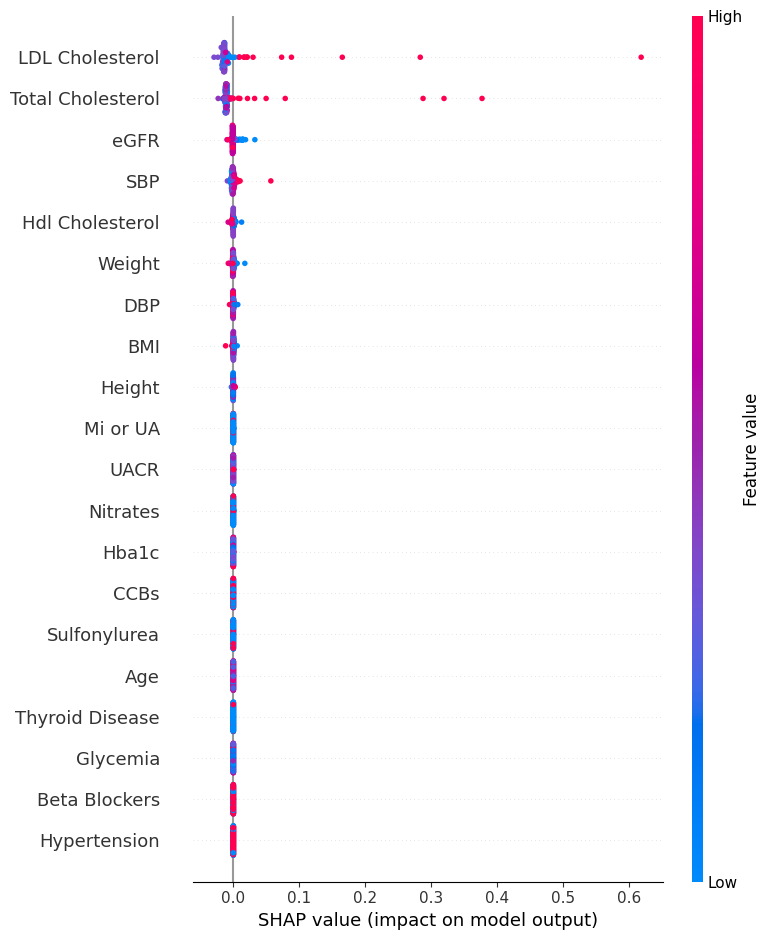

In [10]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="nb",
    sampling="baseline",
    n_splits=5,
    random_state=42,
    explainer="kernel"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.836, 'precision': 0.035, 'sensitivity': 0.467, 'f1_score': 0.065, 'fbeta_2': 0.135, 'roc_auc': np.float64(0.708), 'NNS': 28.429, 'best_params': OrderedDict([('C', 0.00022908307093759842), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.811, 'precision': 0.034, 'sensitivity': 0.571, 'f1_score': 0.065, 'fbeta_2': 0.139, 'roc_auc': np.float64(0.748), 'NNS': 29.0, 'best_params': OrderedDict([('C', 0.00046001210476106976), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.835, 'precision': 0.044, 'sensitivity': 0.643, 'f1_score': 0.082, 'fbeta_2': 0.172, 'roc_auc': np.float64(0.836), 'NNS': 22.778, 'best_params': OrderedDict([('C', 0.0005238499102541385), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.763, 'precision': 0.024, 'sensitivity': 0.5, 'f1_score': 0.046, 'fbeta_2': 0.101, 'roc_auc': np.float64(0.688), 'NNS': 41.286, 'best_params': OrderedDict([('C', 0.00

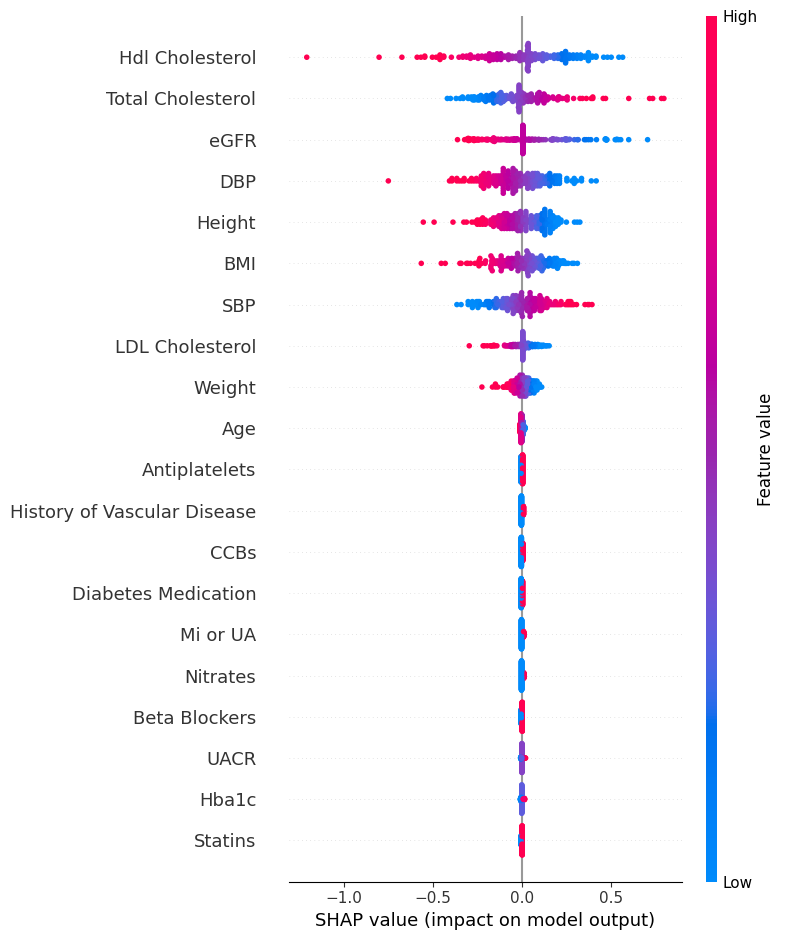

In [7]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="linear"
)


=== Technique: UNDERSAMPLE ===
{'fold': 1, 'accuracy': 0.836, 'precision': 0.035, 'sensitivity': 0.467, 'f1_score': 0.065, 'fbeta_2': 0.135, 'roc_auc': np.float64(0.708), 'NNS': 28.429, 'best_params': OrderedDict([('C', 0.00022908307093759842), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 2, 'accuracy': 0.811, 'precision': 0.034, 'sensitivity': 0.571, 'f1_score': 0.065, 'fbeta_2': 0.139, 'roc_auc': np.float64(0.748), 'NNS': 29.0, 'best_params': OrderedDict([('C', 0.00046001210476106976), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 3, 'accuracy': 0.835, 'precision': 0.044, 'sensitivity': 0.643, 'f1_score': 0.082, 'fbeta_2': 0.172, 'roc_auc': np.float64(0.836), 'NNS': 22.778, 'best_params': OrderedDict([('C', 0.0005238499102541385), ('penalty', 'l2'), ('solver', 'liblinear')])}
{'fold': 4, 'accuracy': 0.763, 'precision': 0.024, 'sensitivity': 0.5, 'f1_score': 0.046, 'fbeta_2': 0.101, 'roc_auc': np.float64(0.688), 'NNS': 41.286, 'best_params': OrderedDict([('C', 0.00

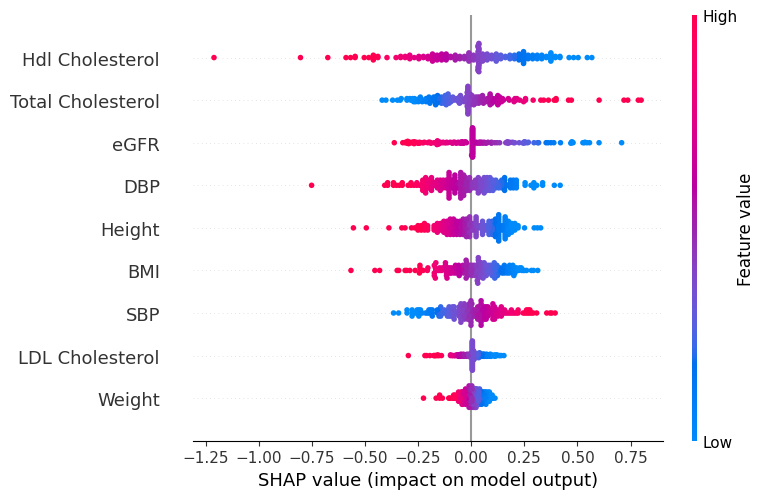

In [8]:
results = run_cv_with_sampling(
    X_full=data_static,
    target_cols=targets,
    target_name="y_acs_6_months",
    optimizer_map=optimizer_map,
    model_name="lr",
    sampling="undersample",
    n_splits=5,
    random_state=42,
    explainer="linear",
    max_disp=9
)